## Water Potability 

### IS your water safe to drink? 

#### Are you gonna be a 1 ;p or a 0 xp ?

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
# not necessary once downloaded
# path = !wget http://www.keshavmaheshwari.us/images/water_potability.csv

In [3]:
water_data = pd.read_csv('water_potability.csv')

print(water_data.shape)
water_data.head(10)

(3276, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


<AxesSubplot:>

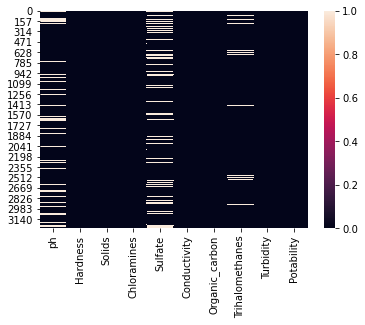

In [4]:
sns.heatmap(water_data.isnull())

In [5]:
def split_data(df):
    training_set, testing_set = train_test_split(df)
    tns = training_set.reset_index(drop=True)
    tts = testing_set.reset_index(drop=True)
    return tns, tts

In [6]:
train1, test1 = split_data(water_data)

print(train1.shape)
print(test1.shape)

(2457, 10)
(819, 10)


training set 1 heatmap: 


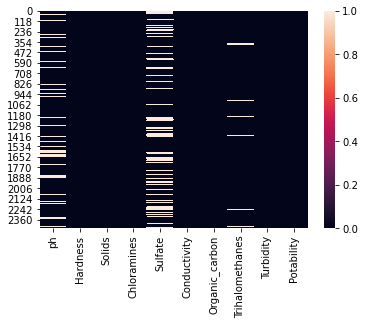

In [7]:
print("training set 1 heatmap: ")
p1 = sns.heatmap(train1.isnull())

testing set 1 heatmap: 


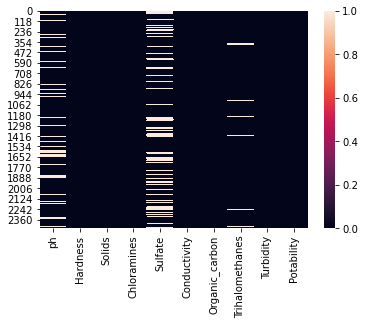

In [8]:
print("testing set 1 heatmap: ")
p2 = sns.heatmap(train1.isnull())

In [9]:
train2, test2 = split_data(water_data)
print(train2.shape)
print(test2.shape)

test2.head()

(2457, 10)
(819, 10)


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,5.991283,224.608563,29983.116007,7.383819,329.731547,604.631263,17.741228,65.116976,4.840562,1
1,6.549188,212.922141,19236.012495,7.960190,NaN,424.398027,12.587048,49.585573,4.190311,1
2,4.758648,203.537832,23603.065417,7.667128,324.084334,288.912457,18.064957,85.916666,4.405509,0
3,NaN,213.541932,22539.711615,6.957204,334.041186,463.398847,11.623019,69.615850,3.398593,0
4,NaN,204.852187,13286.156575,9.093843,332.845544,365.687520,8.589896,76.306376,4.268525,1


In [10]:
def impute_missing_data(training_set, testing_set):
    train_s = impute_features(training_set)
    test_s = impute_features(testing_set)
    return (train_s, test_s)


def impute_features(input_dataset):
    dataset = input_dataset.copy()
    count = 0
    for i in dataset:
        no_na_column = dataset[i].dropna().values
        mean = sum(no_na_column) / len(no_na_column)
        na_map_list = list(dataset[i].isna().values)
        for b in range(len(na_map_list)):
            if na_map_list[b] == True:
                count +=1
                dataset.__getitem__(i).__setitem__(b, mean)
                #dataset.iloc[i][b] = mode
    return dataset.copy()


def distance(row1, row2):
    d = 0
    for a, b in zip(row1, row2):
        c = abs(a - b)
        d += (c ** (1/2))
    return np.sqrt(d)


def predict(training_set, testing_set, k_nearest):
    predictions = []
    for i in tqdm(range(int(testing_set.shape[0]))):
        recorded_vals = []
        rowTest = testing_set.loc[i].values
        for j in range(int(training_set.shape[0])):
            rowTrain = training_set.iloc[j].values
            dist = distance(rowTrain, rowTest)
            val = rowTrain[-1]
            recorded_vals += [(dist, val)]
        topk_outcomes = [label for (dist, label) in sorted(recorded_vals)[:k_nearest]]
        labels = set(topk_outcomes)
        outcomes = []
        for label in labels:
            count = topk_outcomes.count(label)
            outcomes += [(count, label)]
        (_, outcome) = max(outcomes)
        predictions += [outcome]
    return predictions

def compare(training_set, testing_set, k):
    predicted = predict(training_set, testing_set, k)
    actual = list(testing_set.iloc[:, -1].values)
    comparison = pd.DataFrame(list(zip(predicted, actual)))
    return (predicted, actual)

def accuracy(predicted, actual):
    correct = 0
    for i in range(len(predicted)):
        if predicted[i] == actual[i]:
            correct += 1
    return correct / len(predicted)

def run_test(trnS, tstS, k, treatment=False):
    if treatment:
        (trnS, tstS) = impute_missing_data(trnS, tstS)
    (pred, act) = compare(trnS, tstS, k)
    acc = accuracy(pred, act)
    print("trial " + str(k))
    return acc

In [ ]:
import matplotlib.pyplot as plt
import multiprocessing
from joblib import Parallel, delayed

k_range = list(range(1,100,2))
num_cores = multiprocessing.cpu_count()
print(num_cores)
inputs = tqdm(k_range)

def fun(k):
  acc = run_test(train2, test2, k, True)
  return acc

executor = Parallel(n_jobs=num_cores, backend= 'multiprocessing')
tasks = (delayed(fun)(i) for i in inputs)
acc_list = executor(tasks)

plt.plot(k_range, acc_list)
plt.xlabel('Value of k for KNN')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Values of k of k-Nearest-Neighbors')
plt.show()

4


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
def printResults(acc_list, k_list):
    for k in range(len(acc_list)):
        print("For k = " + str(k_list[k]) + ",")
        print("accuracy = " + str(acc_list[k]))
    print("MAX acc: " + str(max(acc_list)))
    
printResults(acc_list, k_range)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X = impute_features(water_data)

inputs = X.drop('Potability', axis=1)
outputs = X['Potability']

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs)

logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

print(classification_report(y_test, predictions))

In [ ]:
# run_test(train1, test1, 1, True)
# run_test(train1, test1, 3, True)
# run_test(train1, test1, 5, True)
# run_test(train1, test1, 7, True)
# run_test(train1, test1, 9, True)
# run_test(train1, test1, 11, True)
# run_test(train2, test2, 13, True)
# run_test(train1, test1, 31, True)
# run_test(train1, test1, 33, True)